In [740]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from elosports.elo import Elo
import pprint

from datetime import datetime

In [798]:
szn = '2018-19'
szn_m = '2018_2019'
num_games = 82
sigma = 14

df = pd.read_csv(f'{szn}_odds_parsed.csv')
df['gameid'] = df['v'].str[0] + df['final_v'].astype(str) + df['h'].str[0] + df['final_h'].astype(str)
df

,Unnamed: 0,Date,v,final_v,ml_v,h,final_h,ml_h,total_open,total_close,spread_open,spread_close,gameid
0,0,1016,Philadelphia,87,170,Boston,105,-200,208.5,211.5,-5.0,-4.5,P87B105
1,1,1016,OklahomaCity,100,711,GoldenState,108,-1100,223.5,220.5,-11.5,-12.0,O100G108
2,2,1017,Memphis,83,263,Indiana,111,-325,209.0,204.5,-7.0,-7.5,M83I111
3,3,1017,Milwaukee,113,-165,Charlotte,112,144,217.0,222.0,1.5,3.0,M113C112
4,4,1017,Miami,101,-135,Orlando,104,115,210.5,208.0,2.0,2.5,M101O104
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,1307,602,GoldenState,109,117,Toronto,104,-137,216.0,213.5,1.0,-2.5,G109T104
1308,1308,605,Toronto,123,114,GoldenState,109,-134,214.0,209.5,-5.5,-2.5,T123G109
1309,1309,607,Toronto,105,194,GoldenState,92,-233,216.0,215.0,-4.5,-5.0,T105G92
1310,1310,610,GoldenState,106,-107,Toronto,105,-113,212.0,217.0,-3.0,-1.0,G106T105


In [799]:
df1 = pd.read_csv(f'{szn_m}_merged.csv')
df1['gameid'] = df1['Visitor/Neutral'].str[0] + df1['PTS'].astype(str) \
                + df1['Home/Neutral'].str[0] + df1['PTS.1'].astype(str)
df1['Date'] = df1['Date'].apply(lambda x: datetime.strptime(x, '%a, %b %d, %Y').strftime('%Y%m%d'))
df1

,Unnamed: 0,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,gameid
0,0,20181016,8:00p,Philadelphia 76ers,87,Boston Celtics,105,Box Score,NaN,"18,624",NaN,P87B105
1,1,20181016,10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,"19,596",NaN,O100G108
2,2,20181017,7:00p,Milwaukee Bucks,113,Charlotte Hornets,112,Box Score,NaN,"17,889",NaN,M113C112
3,3,20181017,7:00p,Brooklyn Nets,100,Detroit Pistons,103,Box Score,NaN,"20,332",NaN,B100D103
4,4,20181017,7:00p,Memphis Grizzlies,83,Indiana Pacers,111,Box Score,NaN,"17,923",NaN,M83I111
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,1307,20190602,8:00p,Golden State Warriors,109,Toronto Raptors,104,Box Score,NaN,"20,014",NaN,G109T104
1308,1308,20190605,9:00p,Toronto Raptors,123,Golden State Warriors,109,Box Score,NaN,"19,596",NaN,T123G109
1309,1309,20190607,9:00p,Toronto Raptors,105,Golden State Warriors,92,Box Score,NaN,"19,596",NaN,T105G92
1310,1310,20190610,9:00p,Golden State Warriors,106,Toronto Raptors,105,Box Score,NaN,"20,144",NaN,G106T105


In [800]:
team_dict = {'Los Angeles Lakers': 'LALakers',
             'Milwaukee Bucks': 'Milwaukee',
             'Brooklyn Nets': 'Brooklyn',
             'Los Angeles Clippers': 'LAClippers',
             'Boston Celtics': 'Boston',
             'Miami Heat': 'Miami',
             'Denver Nuggets': 'Denver',
             'Golden State Warriors': 'GoldenState',
             'Toronto Raptors': 'Toronto',
             'Philadelphia 76ers': 'Philadelphia',
             'Dallas Mavericks': 'Dallas',
             'Utah Jazz': 'Utah',
             'Portland Trail Blazers': 'Portland',
             'Phoenix Suns': 'Phoenix',
             'Houston Rockets': 'Houston',
             'New Orleans Pelicans': 'NewOrleans',
             'Atlanta Hawks': 'Atlanta',
             'Indiana Pacers': 'Indiana',
             'Washington Wizards': 'Washington',
             'Memphis Grizzlies': 'Memphis',
             'Minnesota Timberwolves': 'Minnesota',
             'Oklahoma City Thunder': 'OklahomaCity',
             'Orlando Magic': 'Orlando',
             'Chicago Bulls': 'Chicago',
             'Charlotte Hornets': 'Charlotte',
             'Sacramento Kings': 'Sacramento',
             'San Antonio Spurs': 'SanAntonio',
             'New York Knicks': 'NewYork',
             'Cleveland Cavaliers': 'Cleveland',
             'Detroit Pistons': 'Detroit',}

In [801]:
def update_elo(df, eloLeague, home, away, home_score, away_score):

    for game in df.iterrows():
    # 	if game[1].season > currSeason:
    # 		for key in eloLeague.ratingDict.keys():
    # 			eloLeague.ratingDict[key] = eloLeague.ratingDict[key] - ((eloLeague.ratingDict[key] - 1500) * (1/3.))
    # 		currSeason += 1
#         print(f'{game[1][away]} {game[1][away_score]} - {game[1][home_score]} {game[1][home]}')
        if game[1][home_score] > game[1][away_score]:
            eloLeague.gameOver(game[1][home], game[1][away], True)
        elif game[1][home_score] < game[1][away_score]:
            eloLeague.gameOver(game[1][away], game[1][home], False)
#     display(dict(sorted(eloLeague.ratingDict.items(), key=lambda item: item[1], reverse=True)))
    return eloLeague

def odds_to_prob(x):
    if x < 0:
        return round(abs(x) / (100+abs(x)), 4)
    else:
        return round(100 / (100+abs(x)), 4)
    
def prob_to_spread(prob):
    spread = round(norm.ppf(prob)*sigma, 2)
    if prob > 0.5:
        return -1*spread
    else:
        return spread
    
def spread_winprob(diff):
    away_spread_winprob = round(norm.cdf(diff/sigma), 4)
    home_spread_winprob = 1 - away_spread_winprob
#     return max(away_spread_winprob, home_spread_winprob)
    return home_spread_winprob

def bet(home_winprob):
    r = 10/11
    p = max(home_winprob, 1 - home_winprob)
    if p < threshold:
        return 0
    kelly = (p*r + p - 1)/r
#     frac = 1
    
    # FADE MYSELF???
    if home_winprob > 0.5:
        return -1*frac*kelly
    else:
        return frac*kelly

def get_wealth(df, prev=1000, ret=10/11):
    wealths = []
    for game in df.iterrows():
        exposure_frac = game[1]['home_win_ats'] * game[1]['bet_size']
        if exposure_frac == 0:
            wealth = prev
        elif exposure_frac > 0:
            wealth = prev + ret*exposure_frac*prev
        elif exposure_frac < 0:
            wealth = prev + exposure_frac*prev
        wealths.append(wealth)
        prev = wealth
    return wealths

Kelly Fraction: 0.05
Max Wealth: 1071.5126797156308
Final Wealth: 540.7528466395112
Max Bet %: 2.72%

Kelly Fraction: 0.1
Max Wealth: 1145.3476884177728
Final Wealth: 272.6081772401061
Max Bet %: 5.43%

Kelly Fraction: 0.25
Max Wealth: 1378.744818380566
Final Wealth: 22.80271675302956
Max Bet %: 13.58%



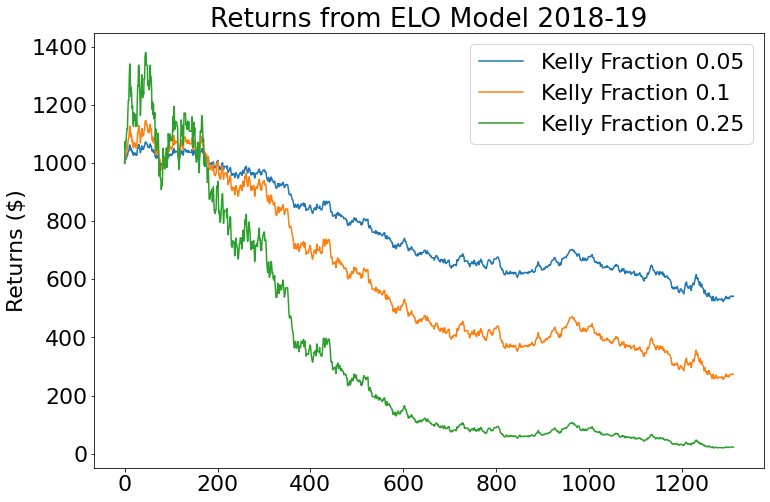

In [802]:
# initial ratings for start of season
# convert to points better than avg/elo??
ps_wins_to_elo = 6
elo_to_points = 28 
k = 20
homefield = 66
threshold = 0.525

ps_df = pd.read_csv(f'preseason odds {szn}.csv')
ps_df['Team'] = ps_df['Team'].apply(lambda x: team_dict[x])
ps_df = ps_df.set_index('Team')
ps_df['Elo'] = ps_df['W-L O/U'].apply(lambda x: (x-num_games/2)*ps_wins_to_elo + 1500)
ps_ratings = dict(ps_df['Elo'])
# display(ps_ratings)

def backtest(df, ps_ratings):
    eloLeague = Elo(k, homefield=homefield)
    for team, rating in ps_ratings.items():
        eloLeague.addPlayer(team, rating=rating)
#     display(dict(sorted(eloLeague.ratingDict.items(), key=lambda item: item[1], reverse=True)))
    # for each game: 
    #     use current ratings to predict outcome - append to list
    #     update ratings with actual outcome

    home_winprobs = []
    home_ratings = []
    away_ratings = []
    dates = df['Date'].unique()
    for date in dates:
        today_df = df[df['Date'] == date]

        # predict games
        for game in today_df.iterrows():
            home_winprob = eloLeague.expectResult(eloLeague.ratingDict[game[1]['h']] + homefield, 
                                                  eloLeague.ratingDict[game[1]['v']])
            home_winprobs.append(home_winprob)
            home_ratings.append(eloLeague.ratingDict[game[1]['h']])
            away_ratings.append(eloLeague.ratingDict[game[1]['v']])

        # update ratings
        eloLeague = update_elo(today_df, eloLeague, 'h', 'v', 'final_h', 'final_v')

    df['margin'] = df['final_v'] - df['final_h']
    df['vegas_home_win_prob'] = df['ml_h'].apply(odds_to_prob)
    df['vegas_away_win_prob'] = df['ml_v'].apply(odds_to_prob)
    df['home_rating'] = home_ratings
    df['away_rating'] = away_ratings
    df['home_win_prob'] = [round(prob, 4) for prob in home_winprobs]
    df['away_win_prob'] = 1 - df['home_win_prob']
    # df['pred_spread'] = df['home_win_prob'].apply(prob_to_spread)
    df['pred_spread'] = (df['away_rating'] - df['home_rating'] - homefield) / elo_to_points
    df['spread_diff_vegas'] = df['pred_spread'] - df['spread_close']
    df['vegas_spread_winprob'] = df['spread_diff_vegas'].apply(spread_winprob)
    df['bet_size'] = df['vegas_spread_winprob'].apply(bet)
    df['bet_team'] = df.apply(lambda df: df['v'] if df['bet_size'] > 0 else (df['h'] if df['bet_size'] > 0 else ''),
                                  axis=1)
    df['pred_error'] = df['margin'] - df['pred_spread']
    df['spread_outcome'] = df['pred_error'].apply(lambda x: -1 if x < 0 else 1)
    df['home_win_ats'] = (df['margin'] - df['spread_close']).apply(lambda x: -1 if x < 0 else 1)
#     df['bet_outcome'] = (df['bet_size'] * df['spread_outcome']).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
#     df['bet_outcome'] = (df['bet_size'] * df['home_win_ats']).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['pred_correct'] = (((round(df['vegas_spread_winprob'], 0) - 0.5)*2) * df['home_win_ats'] + 1) / 2
    df['wealth'] = get_wealth(df)
#     display(df)
    print(f"Kelly Fraction: {frac}")
    print(f"Max Wealth: {df['wealth'].max()}")
    print(f"Final Wealth: {df['wealth'].iloc[-1]}")
    print(f"Max Bet %: {round(abs(df['bet_size']).max()*100, 2)}%")
    print()
    return df

# plt.rcParams.update({'font.size': 22})
# plt.rcParams["figure.figsize"] = (12,8)
# for frac in [0.1, 0.25, 0.5]:
#     df2 = backtest(df, ps_ratings)
#     plt.plot(df2.index, np.log(df2['wealth']), label=f'Kelly Fraction {frac}')
#     plt.legend()
# plt.title(f'Log Returns when Fading ELO Model {szn}')
# plt.ylabel('Log Returns')
# plt.show()

plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (12,8)
for frac in [0.05, 0.1, 0.25]:
    df2 = backtest(df, ps_ratings)
    plt.plot(df2.index, df2['wealth'], label=f'Kelly Fraction {frac}')
    plt.legend()
plt.title(f'Returns from ELO Model {szn}')
plt.ylabel('Returns ($)')

plt.show()

In [791]:
df['pred_correct'].mean()

0.4995730145175064

In [780]:
# gs_df = df[(df['v'] == 'GoldenState') | (df['h'] == 'GoldenState')]
# gs_df['rating'] = gs_df.apply(lambda x: x['away_rating'] if x['v'] == 'GoldenState' else x['home_rating'], axis=1)
# gs_df['w'] = gs_df.apply(lambda x: 1 if x['v'] == 'GoldenState' and x['margin'] > 0
#                                      else (1 if x['h'] == 'GoldenState' and x['margin'] < 0 else 0), axis=1)
# gs_df['w_pct'] = gs_df['w'].expanding(min_periods=1).mean()
# gs_df['rating'].plot()
# plt.show()
# gs_df['w_pct'].plot()
# plt.show()

In [781]:
np.std(df['margin'] - df['pred_spread'])

13.242702227976237

In [782]:
ps_df[['Elo']].sort_values('Elo', ascending=False)

,Elo
Team,
GoldenState,1629.0
Boston,1608.0
Houston,1593.0
Toronto,1587.0
Philadelphia,1575.0
Utah,1551.0
LALakers,1545.0
OklahomaCity,1545.0
Milwaukee,1542.0


In [783]:
display(dict(sorted(eloLeague.ratingDict.items(), key=lambda item: item[1], reverse=True)))

{'Milwaukee': 1693.5221466025773,
 'Phoenix': 1673.8581807131704,
 'Brooklyn': 1620.7813000487238,
 'LAClippers': 1616.4817787644406,
 'Utah': 1616.1139127008553,
 'Philadelphia': 1615.4174722222779,
 'Atlanta': 1601.9977859491285,
 'Denver': 1599.0153250398298,
 'Dallas': 1562.233620534317,
 'Portland': 1560.8369317668266,
 'LALakers': 1551.5767334932762,
 'Miami': 1538.8996275363086,
 'NewYork': 1537.846768002119,
 'Memphis': 1533.3665372801486,
 'GoldenState': 1529.9238202555623,
 'Washington': 1504.5844462460498,
 'Boston': 1484.7156296656706,
 'Indiana': 1474.1233368088947,
 'Chicago': 1463.1909676480275,
 'NewOrleans': 1458.0533973083593,
 'SanAntonio': 1450.5248318531692,
 'Sacramento': 1450.2117593927605,
 'Charlotte': 1430.8185237141709,
 'Minnesota': 1414.8199385452795,
 'Toronto': 1395.4374687177092,
 'Orlando': 1335.6891897640453,
 'Detroit': 1333.020269680467,
 'Cleveland': 1323.9789874865153,
 'OklahomaCity': 1320.1478254120927,
 'Houston': 1308.8114868472258}

In [784]:
df.to_csv(f'nba_betting_{szn}.csv')
ps_df[['Elo']].sort_values('Elo', ascending=False).to_csv(f'preseason_elo_{szn}.csv')

In [570]:
# ps_wins_to_elo = 6
# elo_to_points = 37 
# k = 20
# homefield = 92

# ps_df = pd.read_csv('preseason odds 2018-2019.csv')
# ps_df['Team'] = ps_df['Team'].apply(lambda x: team_dict[x])
# ps_df = ps_df.set_index('Team')
# ps_df['Elo'] = ps_df['W-L O/U'].apply(lambda x: (x-41)*ps_wins_to_elo + 1500)
# ps_ratings = dict(ps_df['Elo'])
# # display(ps_ratings)

# eloLeague = Elo(k, homefield=homefield)
# for team, rating in ps_ratings.items():
#     eloLeague.addPlayer(team, rating=rating)

# e = update_elo(df.iloc[:1311], eloLeague, 'h', 'v', 'final_h', 'final_v')
# display(dict(sorted(e.ratingDict.items(), key=lambda item: item[1], reverse=True)))

In [571]:
ps_df['W-L O/U'].mean()

41.13333333333333

In [572]:
(49.5 - 36)*6 + 1500

1581.0

In [573]:
df['pnl'] = df['wealth'] - df['wealth'].shift().fillna(1000)
df.groupby('Date')['pnl'].sum()

Date
1019        0.000000
1020      406.896630
1021       53.033608
1022      697.214774
1023      191.231422
1024       33.521441
1025      615.416144
1026      566.000332
1027      223.656860
1028      -69.645885
1029      584.981334
1030     1166.519537
1031      854.505858
1101    -2265.771477
1102      153.051036
1103      110.483530
1104      255.467081
1105     1718.431939
1106     -484.167295
1107    -1002.120418
1108     1153.684042
1109     1442.139650
1110     1427.825670
1111      -12.207096
1112     2307.906532
1113     -841.417139
1114     -409.734834
1115     7302.299367
1116     3427.662901
1117     3834.403242
1118     3459.521195
1119     5527.889921
1120    14145.475720
1121    18383.247473
1122     8800.557914
1123    29864.441895
1124    34498.366600
1126    41507.645304
1127    14706.171629
1128     4644.319868
1129    -6672.096188
1130    -5194.153988
Name: pnl, dtype: float64

In [558]:
def test(df1, date, spreads):    
    df = df1[df1['Date'] == date][['Visitor/Neutral', 'Home/Neutral']]
    df = df.rename(columns={'Visitor/Neutral': 'v', 'Home/Neutral': 'h'})
    df['h'] = df['h'].apply(lambda x: team_dict[x])
    df['v'] = df['v'].apply(lambda x: team_dict[x])

    home_ratings, away_ratings = [], []
    for game in df.iterrows():
    #     home_winprob = eloLeague.expectResult(eloLeague.ratingDict[game[1]['h']] + homefield, 
    #                                           eloLeague.ratingDict[game[1]['v']])
        home_winprobs.append(home_winprob)
        home_ratings.append(eloLeague.ratingDict[game[1]['h']])
        away_ratings.append(eloLeague.ratingDict[game[1]['v']])

    df['home_rating'] = home_ratings
    df['away_rating'] = away_ratings
    df['pred_spread'] = (df['away_rating'] - df['home_rating'] - homefield) / elo_to_points
    df['spread_close'] = spreads
    df['spread_diff_vegas'] = df['pred_spread'] - df['spread_close']
    df['vegas_spread_winprob'] = df['spread_diff_vegas'].apply(spread_winprob)
    df['bet_size'] = df['vegas_spread_winprob'].apply(bet)
    df['bet_team'] = df.apply(lambda df: df['v'] if df['bet_size'] > 0 else (df['h'] if df['bet_size'] > 0 else ''),
                              axis=1)
#     df['pred_error'] = df['margin'] - df['pred_spread']
#     df['spread_outcome'] = df['pred_error'].apply(lambda x: -1 if x < 0 else 1)
#     df['bet_outcome'] = (df['bet_size'] * df['spread_outcome']).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
#     df['wealth'] = get_wealth(df)
    display(df)

spreads = [-2, 8, -3.5, -3, -3, -9, 4, -2.5, -6]
test(df1, '20211201', spreads)


,v,h,home_rating,away_rating,pred_spread,spread_close,spread_diff_vegas,vegas_spread_winprob,bet_size,bet_team
318,Atlanta,Indiana,1482.099386,1542.019368,-0.217144,-2.0,1.782856,0.4493,-0.028235,
319,Denver,Orlando,1336.787650,1525.345326,4.377060,8.0,-3.622940,0.6021,0.082205,Denver
320,Minnesota,Washington,1508.898885,1493.648212,-2.901810,-3.5,0.598190,0.4830,0.000000,
321,Philadelphia,Boston,1524.218440,1533.148229,-2.038222,-3.0,0.961778,0.4726,-0.003770,
322,Cleveland,Miami,1570.054629,1465.214868,-6.101420,-3.0,-3.101420,0.5877,0.067085,Cleveland
323,Charlotte,Milwaukee,1581.547374,1519.204340,-4.583680,-9.0,4.416320,0.3762,-0.104990,
324,Dallas,NewOrleans,1437.591595,1531.224791,0.986900,4.0,-3.013100,0.5852,0.064460,Dallas
325,Houston,OklahomaCity,1374.342204,1369.336230,-2.535928,-2.5,-0.035928,0.5010,0.000000,
326,Sacramento,LAClippers,1500.399131,1435.091510,-4.689558,-6.0,1.310442,0.4627,-0.014165,
